In [780]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from semopy import Model, calc_stats, semplot, report
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

In [781]:
df = pd.read_spss('C:\\data\\education\\한국아동청소년행복지수조사\\kor_data_20210010.sav')
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,q512,q513,q514,q52,q53,q5411,q5412,q5421,q5422,wt
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,해당 없음,차이 없음,차이 없음,28.0,그대로다,NaN,NaN,NaN,NaN,0.250048
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,20.0,그대로다,NaN,NaN,NaN,NaN,0.250048
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,차이 없음,차이 없음,차이 없음,30.0,그대로다,NaN,NaN,NaN,NaN,0.250048


In [782]:
# df = df[df['school'] == '고등학생']
# df.head(3)

In [783]:
len(df)

5376

In [784]:
def null0(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    return df

In [785]:
def encoding(df, columns, category_map): 
    df[columns] = df[columns].replace(category_map)
    return df

category4_map = {
    '전혀 그렇지 않다': 0,
    '그렇지 않다': 1,
    '그렇다': 2,
    '매우 그렇다': 3
}
category5_map = {
    '전혀 그렇지 않다': 0,
    '별로 그렇지 않다': 1,
    '보통이다' : 2,
    '조금 그렇다': 3,
    '매우 그렇다': 4
}
reverse_category5_map = {
    '전혀 그렇지 않다': 4,
    '별로 그렇지 않다': 3,
    '보통이다' : 2,
    '조금 그렇다': 1,
    '매우 그렇다': 0
}
how_serious_map = {
    '전혀 심각하지 않다' : 0,
    '별로 심각하지 않다' : 1,
    '보통이다' : 2,
    '약간 심각한 편이다' : 3,
    '매우 심각하다' : 4
}
how_often_map = {
'경험이 전혀 없거나 거의 없었다' : 2,
'1년에 몇 번 있었다' : 1,
'한 달에 몇 번 있었다' : 0,
'일주일에 한번 이상 있었다' : 0 
}
happy_map = {
'매우 행복하다' : 4,
'대체로 행복한 편이다' : 3,
'모르겠다' : 2,
'별로 행복하지 않은 편이다' : 1,
'전혀 행복하지 않다' : 0
}
how_happy_map = {
'매우 행복하다' : 4,
'약간 행복하다' : 3,
'보통이다' : 2,
'약간 불행하다' : 1,
'매우 불행하다' : 0
}
yes_or_no_map = {
'예' : 1,
'아니오' : 0
}
is_or_not_map = {
    '있다' : 1,
    '없다' : 0
}
is_or_not_map2 = {
    '있다' : 2,
    '없다' : 1
}
how_much_is_map = {
    '전혀 없다' : 0,
    '1~2번 있다' : 1,
    '3~4번 있다' : 2,
    '5번 이상 있다' : 2
}
how_high_map = {
    '상의 상' : 2,
    '상의 하': 2,
    '중의 상': 1,
    '중의 하': 1,
    '하의 상': 0, 
    '하의 하': 0
}

In [786]:
def time_min(df, hour_column, minute_column):
    # 시간과 분 열의 결측값을 0으로 채움
    df[hour_column] = df[hour_column].fillna(0)
    df[minute_column] = df[minute_column].fillna(0)
    
    # 데이터 타입을 float로 변환
    df[hour_column] = df[hour_column].astype(float)
    df[minute_column] = df[minute_column].astype(float)

    # 총 분 계산
    df['pri_edu_time'] = df[hour_column] * 60 + df[minute_column]
    return df

In [787]:
def not_applicable(df, columns):
    for col in columns:
        df[col] = df[col].replace({'해당사항 없음': '보통이다'})
    return df

In [788]:
def weighted_cov(X, weights):
    average = np.average(X, axis=0, weights=weights)
    X_centered = X - average
    cov_matrix = np.dot((X_centered * weights[:, None]).T, X_centered) / (weights.sum() - 1)
    return cov_matrix

In [789]:
def calculate_covariance(df, observed_vars):
    data_for_cov = df[observed_vars].apply(pd.to_numeric, errors='coerce')
    weights = df['wt'].to_numpy()
    w_cov = weighted_cov(data_for_cov.to_numpy(), weights)
    return pd.DataFrame(w_cov, index=observed_vars, columns=observed_vars)

In [790]:
def compute_vif(df, observed_vars):
    X = df[observed_vars].apply(pd.to_numeric, errors='coerce').dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [791]:
def fit_sem_model(model, df, w_cov_df):
    model.fit(df, cov=w_cov_df)
    return model

In [792]:
def calculate_bmi(df, height, weight):
    df[height] = pd.to_numeric(df[height], errors='coerce')
    df[weight] = pd.to_numeric(df[weight], errors='coerce')
    
    df['bmi'] = df[weight] / ((df[height] / 100) ** 2)
    df['bmi'] = df['bmi'].round(2)
    return df

In [793]:
# 표준화 계수 계산 함수
def standardize_estimates(df, data):
    std_estimates = []
    for _, row in df.iterrows():
        if row['op'] == '~':  # 회귀 계수
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                y_std = np.std(data[row['lhs']], ddof=1)
                std_beta = row['Estimate'] * (x_std / y_std)
                std_estimates.append(std_beta)
            except KeyError:
                std_estimates.append(np.nan)
        elif row['op'] == '=~':  # 요인 부하량
            try:
                x_std = np.std(data[row['rhs']], ddof=1)
                std_estimates.append(row['Estimate'] * x_std)
            except KeyError:
                std_estimates.append(np.nan)
        else:
            std_estimates.append(np.nan)
    df['std_estimate'] = std_estimates
    return df

# 학업압박

In [794]:
df_edu = df[['q071','q072', 'q073', 'q074'] + ['q485', 'q486', 'q487', 'q488']]
df_edu = null0(df_edu)

df_edu = encoding(df_edu, ['q071', 'q072', 'q073', 'q074'], category4_map)
df_edu = encoding(df_edu, ['q485', 'q486','q487', 'q488'], category5_map)

In [795]:
model_desc = """
academic_stress =~ q072 + q073
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety
academic_stress ~~ exam_anxiety
"""

In [796]:
df_edu['wt'] = df['wt']
observed_vars = ['q072', 'q073', 'q485', 'q486', 'q487', 'q488']
w_cov_df = calculate_covariance(df_edu, observed_vars)

적합도 지표:
                       Value
DoF                6.000000
DoF Baseline      15.000000
chi2             241.352132
chi2 p-value       0.000000
chi2 Baseline  14606.987740
CFI                0.983871
GFI                0.983477
AGFI               0.958692
NFI                0.983477
TLI                0.959678
RMSEA              0.085427
AIC               29.910211
BIC              128.755709
LogLik             0.044894 


모수 추정치:
                  lval  op               rval  Estimate  Std. Err    z-value  \
0     academic_stress   ~  academic_pressure  1.000000         -          -   
1        exam_anxiety   ~  academic_pressure -0.233253  0.004325 -53.928922   
2                q072   ~    academic_stress  1.000000         -          -   
3                q073   ~    academic_stress  0.833597   0.01737  47.991626   
4                q485   ~       exam_anxiety  1.000000         -          -   
5                q486   ~       exam_anxiety  1.009867  0.016662  60.608563   
6     

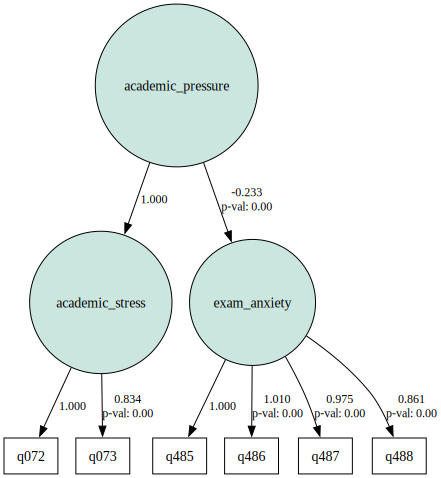

In [797]:
model = Model(model_desc)
model = fit_sem_model(model, df_edu, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\academic_pressure.png')

In [798]:
factor_scores = model.predict_factors(df_edu)

df["academic_pressure"] = factor_scores["academic_pressure"]
df['academic_stress'] = factor_scores["academic_stress"]
df['exam_anxiety'] = factor_scores["exam_anxiety"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...   q52   q53 q5411 q5412 q5421 q5422        wt  \
0   아니오   아니오  ...  28.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
1     예     예  ...  20.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
2     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.250048   
3     예     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   
4   아니오     예  ...  30.0  그대로다   NaN   NaN   NaN   NaN  0.244036   

  academic_pressure academic_stress exam_anxiety  
0         -1.343737       -1.420650     0.011086  
1         -0.328167       -0.696

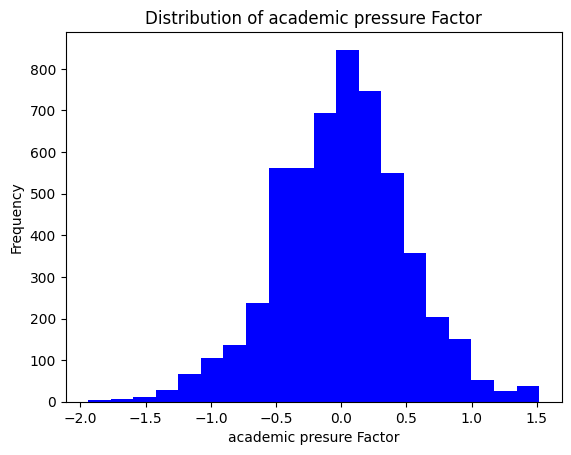

In [799]:
plt.hist(df["academic_pressure"], bins=20, color='blue')
plt.title("Distribution of academic pressure Factor")
plt.xlabel("academic presure Factor")
plt.ylabel("Frequency")
plt.show()

# 인간 관계

In [800]:
df_rel = df[['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225', 'q132']]
df_rel.columns

Index(['q05', 'q136', 'q061', 'q062', 'q161', 'q162', 'q163', 'q164', 'q171',
       'q172', 'q173', 'q174', 'q224', 'q225', 'q132'],
      dtype='object')

In [801]:
df_rel['q172'].value_counts()

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

In [802]:
df_rel = not_applicable(df_rel, ['q132', 'q136','q171','q172','q162', 'q161', 'q163', 'q164', 'q173', 'q174', 'q224'])
df_rel = encoding(df_rel, ['q05', 'q136','q061','q062','q161','q162','q163','q164','q171','q172','q173','q174','q224','q225'], category5_map)
df_rel = encoding(df_rel, ['q132'], reverse_category5_map)
df_rel = pd.DataFrame(scaler.fit_transform(df_rel), columns=df_rel.columns)
df_rel.head(3)

,q05,q136,q061,q062,q161,q162,q163,q164,q171,q172,q173,q174,q224,q225,q132
0,1.00,1.0,0.75,0.00,1.0,1.0,1.00,0.25,1.0,1.0,1.00,0.25,0.50,0.25,1.0
1,0.75,1.0,0.75,0.25,1.0,1.0,1.00,0.75,1.0,1.0,1.00,0.75,0.75,0.75,1.0
2,1.00,0.0,1.00,1.00,1.0,1.0,0.75,0.75,0.5,0.5,0.75,0.50,0.50,1.00,1.0


In [803]:
model_desc = """
friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q162
mother_rel =~ q171 + q172
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225

human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel

father_rel ~~ mother_rel
"""

In [804]:
df_rel['wt'] = df['wt']
observed_vars = ['q132', 'q136', 'q061', 'q062','q161','q162','q171','q172','q224', 'q225']
w_cov_df = calculate_covariance(df_rel, observed_vars)

적합도 지표:
                       Value
DoF               28.000000
DoF Baseline      45.000000
chi2             451.718466
chi2 p-value       0.000000
chi2 Baseline  14970.522565
CFI                0.971611
GFI                0.969826
AGFI               0.951506
NFI                0.969826
TLI                0.954375
RMSEA              0.053060
AIC               53.831950
BIC              231.753847
LogLik             0.084025 


모수 추정치:
            lval  op         rval  Estimate  Std. Err    z-value   p-value
0    father_rel   ~   parent_rel  1.000000         -          -         -
1    mother_rel   ~   parent_rel  0.847670   0.03898  21.746439       0.0
2    friend_rel   ~    human_rel  1.000000         -          -         -
3   teacher_rel   ~    human_rel  1.794772  0.103353  17.365483       0.0
4    parent_rel   ~    human_rel  1.271853  0.083186  15.289221       0.0
5     group_rel   ~    human_rel  2.135424  0.134696  15.853643       0.0
6          q132   ~   friend_rel  1.00000

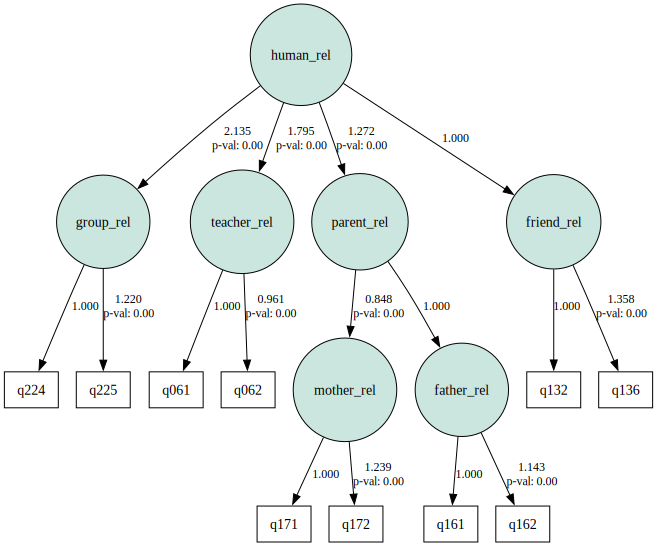

In [805]:
vif_df = compute_vif(df_rel, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_rel, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\human_rel.png')

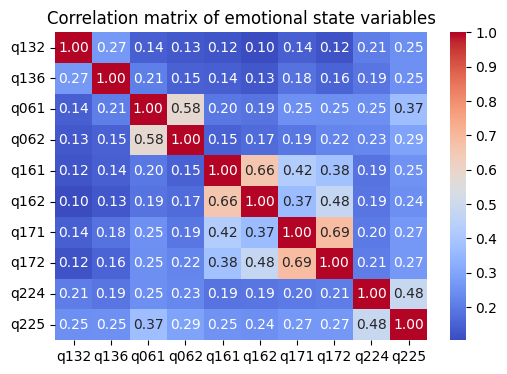

In [806]:
# 문제된 변수만 추출
rel_corr_df = df_rel[observed_vars].copy()

# 상관행렬 계산
corr_matrix = rel_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [807]:
factor_scores = model.predict_factors(df_rel)

df["human_rel"] = factor_scores["human_rel"]
df['teacher_rel'] = factor_scores["teacher_rel"]
df['friend_rel'] = factor_scores["friend_rel"]
df['parent_rel'] = factor_scores["parent_rel"]
df['group_rel'] = factor_scores["group_rel"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... q5422        wt academic_pressure academic_stress  \
0   아니오   아니오  ...   NaN  0.250048         -1.343737       -1.420650   
1     예     예  ...   NaN  0.250048         -0.328167       -0.696216   
2     예     예  ...   NaN  0.250048         -1.219588       -1.455488   
3     예     예  ...   NaN  0.244036          0.058480        0.204699   
4   아니오     예  ...   NaN  0.244036         -1.118252       -0.474512   

  exam_anxiety human_rel teacher_rel friend_rel parent_rel group_rel  
0     0.011086 -0.046466   -0.106642   

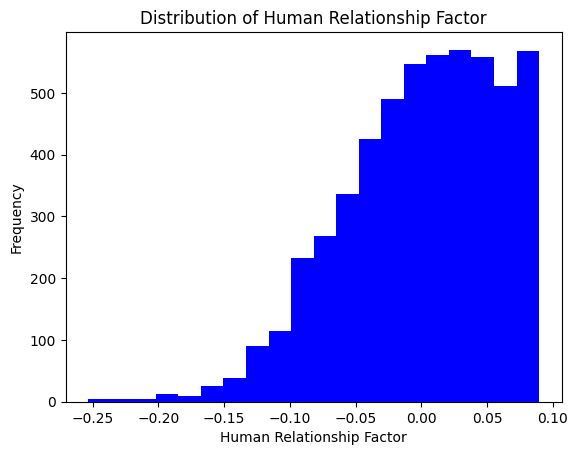

In [808]:
plt.hist(df["human_rel"], bins=20, color='blue')
plt.title("Distribution of Human Relationship Factor")
plt.xlabel("Human Relationship Factor")
plt.ylabel("Frequency")
plt.show()

# 정서적 상태

In [809]:
emo = df[['q221', 'q222', 'q223', 'q226', 'q23', 'q26']]
emo.isnull().sum()

q221    0
q222    0
q223    0
q226    0
q23     0
q26     0
dtype: int64

In [810]:
for i in emo.columns:
    display(emo[i].value_counts())

q221
매우 그렇다       1998
조금 그렇다       1508
보통이다         1225
별로 그렇지 않다     506
전혀 그렇지 않다     139
Name: count, dtype: int64

q222
매우 그렇다       1815
조금 그렇다       1546
보통이다         1256
별로 그렇지 않다     507
전혀 그렇지 않다     252
Name: count, dtype: int64

q223
매우 그렇다       1605
조금 그렇다       1464
보통이다         1454
별로 그렇지 않다     610
전혀 그렇지 않다     243
Name: count, dtype: int64

q226
전혀 그렇지 않다    1575
별로 그렇지 않다    1463
보통이다         1150
조금 그렇다        798
매우 그렇다        390
Name: count, dtype: int64

q23
대체로 행복한 편이다       3106
매우 행복하다           1063
별로 행복하지 않은 편이다     708
모르겠다               388
전혀 행복하지 않다         111
Name: count, dtype: int64

q26
보통이다       1865
약간 행복하다    1450
매우 행복하다    1340
약간 불행하다     575
매우 불행하다     146
Name: count, dtype: int64

In [811]:
emo = encoding(emo, ['q221', 'q222', 'q223'], category5_map)
emo = encoding(emo, ['q226'], reverse_category5_map)
emo = encoding(emo, ['q23'], happy_map)
emo = encoding(emo, ['q26'], how_happy_map)

In [812]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q221    5376 non-null   category
 1   q222    5376 non-null   category
 2   q223    5376 non-null   category
 3   q226    5376 non-null   category
 4   q23     5376 non-null   category
 5   q26     5376 non-null   category
dtypes: category(6)
memory usage: 32.9 KB


In [813]:
scaler = MinMaxScaler()
emo = pd.DataFrame(scaler.fit_transform(emo), columns=emo.columns)

In [814]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   q221    5376 non-null   float64
 1   q222    5376 non-null   float64
 2   q223    5376 non-null   float64
 3   q226    5376 non-null   float64
 4   q23     5376 non-null   float64
 5   q26     5376 non-null   float64
dtypes: float64(6)
memory usage: 252.1 KB


In [815]:
model_desc = """
emotional_state =~ q221 + q223 + q226 + q23
"""

In [816]:
emo['wt'] = df['wt']
observed_vars = ['q221', 'q223', 'q226', 'q23']
w_cov_df = calculate_covariance(emo, observed_vars)

적합도 지표:
                      Value
DoF               2.000000
DoF Baseline      6.000000
chi2             22.569467
chi2 p-value      0.000013
chi2 Baseline  5595.678654
CFI               0.996320
GFI               0.995967
AGFI              0.987900
NFI               0.995967
TLI               0.988960
RMSEA             0.043743
AIC              15.991604
BIC              68.709203
LogLik            0.004198 


모수 추정치:
               lval  op             rval  Estimate  Std. Err    z-value p-value
0             q221   ~  emotional_state  1.000000         -          -       -
1             q223   ~  emotional_state  1.542916  0.039907  38.662765     0.0
2             q226   ~  emotional_state  0.957764  0.032574  29.403152     0.0
3              q23   ~  emotional_state  1.093968  0.028468  38.427411     0.0
4  emotional_state  ~~  emotional_state  0.025571  0.001206  21.202969     0.0
5             q221  ~~             q221  0.049857   0.00109  45.754518     0.0
6             q223  ~

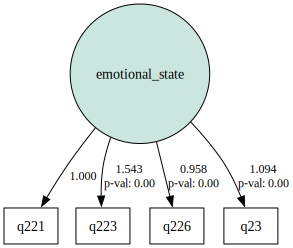

In [817]:
vif_df = compute_vif(emo, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, emo, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\emotional_state.png')

In [818]:
factor_scores = model.predict_factors(emo)

df["emotional_state"] = factor_scores["emotional_state"]

print(df.head())

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ...        wt academic_pressure academic_stress exam_anxiety  \
0   아니오   아니오  ...  0.250048         -1.343737       -1.420650     0.011086   
1     예     예  ...  0.250048         -0.328167       -0.696216    -0.573280   
2     예     예  ...  0.250048         -1.219588       -1.455488    -0.263849   
3     예     예  ...  0.244036          0.058480        0.204699     0.235134   
4   아니오     예  ...  0.244036         -1.118252       -0.474512     1.176400   

  human_rel teacher_rel friend_rel parent_rel group_rel emotional_st

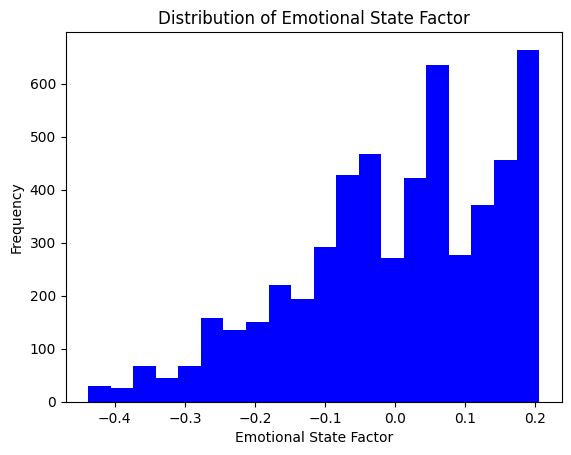

In [819]:
plt.hist(df["emotional_state"], bins=20, color='blue')
plt.title("Distribution of Emotional State Factor")
plt.xlabel("Emotional State Factor")
plt.ylabel("Frequency")
plt.show()

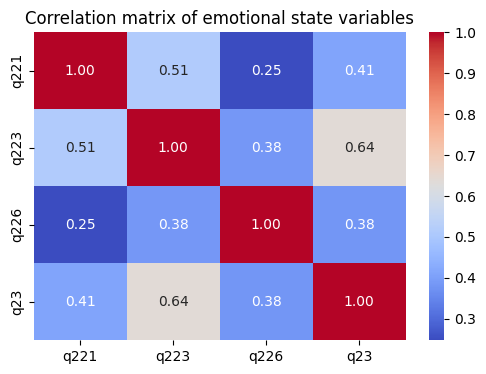

In [820]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문제된 변수만 추출
emo_vars = ['q221', 'q223', 'q226', 'q23']
emo_corr_df = emo[emo_vars].copy()

# 상관행렬 계산
corr_matrix = emo_corr_df.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of emotional state variables')
plt.show()


In [821]:
print(df[df['q35'] == '있다'])

           id sex  birthy birthm                 area         size school  \
8     20009.0  남성  2003.0     7월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
25    20026.0  남성  2003.0     8월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
73    20074.0  여성  2008.0     5월      충청권(대전, 충남, 충북)         중소도시    중학생   
94    20095.0  여성  2003.0     3월      충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   
95    20096.0  남성  2008.0     4월      충청권(대전, 충남, 충북)         중소도시    중학생   
...       ...  ..     ...    ...                  ...          ...    ...   
5196  25197.0  남성  2006.0     8월      호남권(광주, 전남, 전북)         중소도시    중학생   
5218  25219.0  남성  2007.0     6월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5225  25226.0  남성  2007.0     2월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5245  25246.0  여성  2007.0    11월  영남권(부산, 대구, 경남, 경북)         중소도시    중학생   
5343  25344.0  남성  2003.0     5월      수도권(서울, 경기, 인천)          대도시   고등학생   

     grade home1 home2  ...        wt academic_pressure academic_stress  \


# 학교 폭력 노출도

In [822]:
df_vio = df[['q33', 'q35', 'q351', 'q352']]

In [823]:
display(df_vio['q33'].value_counts())
display(df_vio['q35'].value_counts())
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q33
별로 심각하지 않다    1670
전혀 심각하지 않다    1646
보통이다          1313
약간 심각한 편이다     458
매우 심각하다        289
Name: count, dtype: int64

q35
없다    5207
있다     169
Name: count, dtype: int64

q351
1.0       98
2.0       24
3.0       14
5.0        9
4.0        8
모름/무응답     7
10.0       3
20.0       2
6.0        2
9.0        1
50.0       1
Name: count, dtype: int64

q352
1.0       69
2.0       31
3.0       18
4.0       14
10.0       9
모름/무응답     8
5.0        7
6.0        4
8.0        3
20.0       2
9.0        1
7.0        1
17.0       1
16.0       1
Name: count, dtype: int64

In [824]:
df_vio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q33     5376 non-null   category
 1   q35     5376 non-null   category
 2   q351    169 non-null    category
 3   q352    169 non-null    category
dtypes: category(4)
memory usage: 22.5 KB


In [825]:
df_vio = encoding(df_vio, ['q33'], how_serious_map)
df_vio = encoding(df_vio, ['q35'], is_or_not_map)
df_vio['q351'] = df_vio['q351'].replace({'모름/무응답' : 2})
df_vio['q351'] = df_vio['q351'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio['q352'] = df_vio['q352'].replace({'모름/무응답' : 2})
df_vio['q352'] = df_vio['q352'].apply(lambda x: 2 if x >= 2 else (1 if x == 1 else 0))
df_vio = null0(df_vio)
df_vio

,q33,q35,q351,q352
0,0,0,0.0,0.0
1,1,0,0.0,0.0
2,0,0,0.0,0.0
3,2,0,0.0,0.0
4,0,0,0.0,0.0
...,...,...,...,...
5371,0,0,0.0,0.0
5372,1,0,0.0,0.0
5373,3,0,0.0,0.0
5374,0,0,0.0,0.0


In [826]:
display(df_vio['q351'].value_counts())
display(df_vio['q352'].value_counts())

q351
0.0    5207
1.0      98
2.0      71
Name: count, dtype: int64

q352
0.0    5207
2.0     100
1.0      69
Name: count, dtype: int64

In [827]:
model_desc = """
exposure_violence =~ q33 + q35 + q351 + q352
"""

In [828]:

df_vio['wt'] = df['wt']
observed_vars = ['q33', 'q35', 'q351', 'q352']
w_cov_df = calculate_covariance(df_vio, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, df_vio, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                       Value
DoF                2.000000
DoF Baseline       6.000000
chi2              11.230035
chi2 p-value       0.003643
chi2 Baseline  25555.212192
CFI                0.999639
GFI                0.999561
AGFI               0.998682
NFI                0.999561
TLI                0.998916
RMSEA              0.029302
AIC               15.995822
BIC               68.713421
LogLik             0.002089 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0                q33   ~  exposure_violence  1.000000         -          -   
1                q35   ~  exposure_violence  1.225419  0.143113   8.562601   
2               q351   ~  exposure_violence  1.868277   0.21824   8.560674   
3               q352   ~  exposure_violence  2.026795  0.236724   8.561832   
4  exposure_violence  ~~  exposure_violence  0.017143  0.004017   4.268067   
5                q33  ~~                q33  1.234066  0.023808   51.83299   
6            

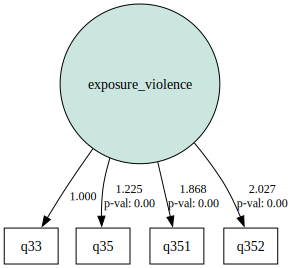

In [829]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\school_violence.png')


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_pressure academic_stress exam_anxiety human_rel  \
0   아니오   아니오  ...         -1.343737       -1.420650     0.011086 -0.046466   
1     예     예  ...         -0.328167       -0.696216    -0.573280  0.024710   
2     예     예  ...         -1.219588       -1.455488    -0.263849  0.015883   
3     예     예  ...          0.058480        0.204699     0.235134 -0.032875   
4   아니오     예  ...         -1.118252       -0.474512     1.176400  0.054596   

  teacher_rel friend_rel parent_rel group_rel emotional_state  \
0  

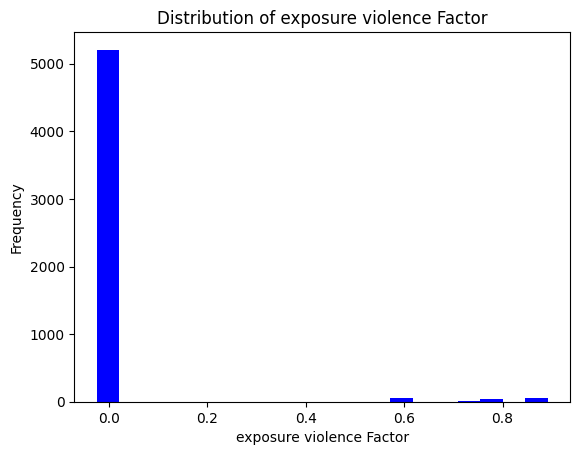

In [830]:
factor_scores = model.predict_factors(df_vio)

df["exposure_violence"] = factor_scores["exposure_violence"]

print(df.head())
plt.hist(df["exposure_violence"], bins=20, color='blue')
plt.title("Distribution of exposure violence Factor")
plt.xlabel("exposure violence Factor")
plt.ylabel("Frequency")
plt.show()

In [831]:
df['exposure_violence'].value_counts()

exposure_violence
-0.024538    1636
-0.024783    1625
-0.024293    1260
-0.024048     418
-0.023803     268
 0.607752      20
 0.891943      18
 0.765818      16
 0.607507      15
 0.891698      14
 0.892188      12
 0.607997       9
 0.607262       9
 0.765573       9
 0.766063       9
 0.766308       8
 0.891453       6
 0.891208       6
 0.733142       4
 0.733878       4
 0.733387       4
 0.733633       3
 0.765328       2
 0.608242       1
Name: count, dtype: int64

# 외모 및 신체 이미지

In [832]:
body = df[['q42', 'q43', 'q4812', 'q4813', 'q4814', 'q4815']]
body.isnull().sum()

q42      0
q43      0
q4812    0
q4813    0
q4814    0
q4815    0
dtype: int64

In [833]:
for i in body.columns:
    display(body[i].value_counts())

q42
160.0    361
170.0    315
165.0    263
158.0    246
163.0    243
        ... 
185.4      1
193.0      1
192.0      1
194.0      1
200.0      1
Name: count, Length: 241, dtype: int64

q43
60.0     269
50.0     266
55.0     238
53.0     195
70.0     191
        ... 
150.0      1
161.0      1
165.0      1
190.0      1
200.0      1
Name: count, Length: 229, dtype: int64

q4812
전혀 그렇지 않다    1959
조금 그렇다       1018
보통이다          952
별로 그렇지 않다     945
매우 그렇다        502
Name: count, dtype: int64

q4813
전혀 그렇지 않다    2346
별로 그렇지 않다    1112
보통이다          885
조금 그렇다        742
매우 그렇다        291
Name: count, dtype: int64

q4814
전혀 그렇지 않다    1984
별로 그렇지 않다    1168
보통이다         1064
조금 그렇다        825
매우 그렇다        335
Name: count, dtype: int64

q4815
전혀 그렇지 않다    2532
별로 그렇지 않다    1156
보통이다          838
조금 그렇다        597
매우 그렇다        253
Name: count, dtype: int64

In [834]:
body = encoding(body, ['q4812', 'q4813', 'q4814', 'q4815'], category5_map)
body = calculate_bmi(body, 'q42', 'q43')
body['obesity'] = body['bmi'].apply(lambda x: (
    0 if x < 18.5 else
    1 if x < 23 else
    2 if x < 25 else
    3 if x < 30 else
    4 if x < 35 else
    5
))

body['obesity'] = body['obesity'].astype('category')

In [835]:
scaler = MinMaxScaler()
body[['q42', 'q43']] = scaler.fit_transform(body[['q42', 'q43']])

In [836]:
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   q42      5317 non-null   float64 
 1   q43      5283 non-null   float64 
 2   q4812    5376 non-null   category
 3   q4813    5376 non-null   category
 4   q4814    5376 non-null   category
 5   q4815    5376 non-null   category
 6   bmi      5283 non-null   float64 
 7   obesity  5376 non-null   category
dtypes: category(5), float64(3)
memory usage: 153.4 KB


In [837]:
body.head(3)

,q42,q43,q4812,q4813,q4814,q4815,bmi,obesity
0,0.58,0.277778,0,0,0,0,28.04,3
1,0.60,0.194444,2,0,0,0,21.48,1
2,0.66,0.188889,2,2,1,1,19.60,1


In [838]:
model_desc = '''
body_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_stress + body_info

q4812 ~~ q4813
q4812 ~~ obesity
'''

In [839]:
body['wt'] = df['wt']
observed_vars = ['q4812', 'q4813', 'q4814','q4815', 'obesity', 'q42', 'q43']
w_cov_df = calculate_covariance(body, observed_vars)
vif_df = compute_vif(body, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, body, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

적합도 지표:
                      Value
DoF               1.000000
DoF Baseline     10.000000
chi2             19.450122
chi2 p-value      0.000010
chi2 Baseline  6457.187876
CFI               0.997138
GFI               0.996988
AGFI              0.969878
NFI               0.996988
TLI               0.971383
RMSEA             0.058588
AIC              27.992764
BIC             120.248562
LogLik            0.003618 


모수 추정치:
                      lval  op                   rval  Estimate  Std. Err  \
0             body_stress   ~  body_image_experience  1.000000         -   
1               body_info   ~  body_image_experience  0.153791  0.037631   
2                   q4812   ~            body_stress  1.000000         -   
3                   q4813   ~            body_stress  0.724073  0.021249   
4                   q4814   ~            body_stress  1.149342  0.027202   
5                   q4815   ~            body_stress  0.945319  0.022608   
6                 obesity   ~             

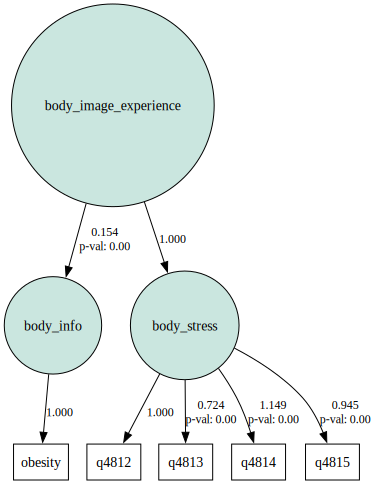

In [840]:
semplot(model, 'C:\\git_files\\education_analysis\\happy\\body_image_experience.png')

In [841]:
factor_scores = model.predict_factors(body)

df["body_image_experience"] = factor_scores["body_image_experience"]

print(df.head())


        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... academic_stress exam_anxiety human_rel teacher_rel  \
0   아니오   아니오  ...       -1.420650     0.011086 -0.046466   -0.106642   
1     예     예  ...       -0.696216    -0.573280  0.024710   -0.028364   
2     예     예  ...       -1.455488    -0.263849  0.015883    0.219782   
3     예     예  ...        0.204699     0.235134 -0.032875   -0.020977   
4   아니오     예  ...       -0.474512     1.176400  0.054596    0.241096   

  friend_rel parent_rel group_rel emotional_state exposure_violence  \
0   0.011224   0.077905 -0.187123

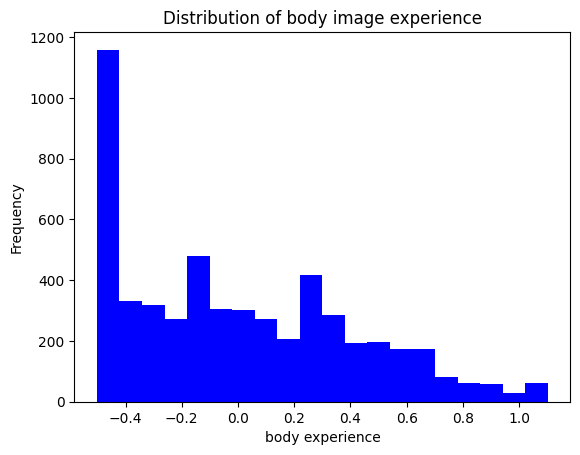

body_image_experience
-0.490741    554
-0.501723    238
-0.103438    145
 0.283865    107
-0.468777    104
            ... 
 0.116204      1
 0.619568      1
 0.145550      1
 0.448571      1
 0.801771      1
Name: count, Length: 1300, dtype: int64

In [842]:
plt.hist(df["body_image_experience"], bins=20, color='blue')
plt.title("Distribution of body image experience")
plt.xlabel("body experience")
plt.ylabel("Frequency")
plt.show()
df['body_image_experience'].value_counts()

# 부모의 관심&지원

In [847]:
# 재정적 지원
financial_support = ['q38', 'q4816', 'q4817']
time_support = ['q162', 'q172']
support = pd.concat([df[financial_support], df[time_support]], axis=1)
support['need_money'] = df['q27'].apply(lambda x: 1 if x == '돈' else 0)
support.head(3)

,q38,q4816,q4817,q162,q172,need_money
0,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,0
1,중의 하,전혀 그렇지 않다,전혀 그렇지 않다,매우 그렇다,매우 그렇다,0
2,중의 상,별로 그렇지 않다,별로 그렇지 않다,매우 그렇다,보통이다,0


In [848]:
for i in support.columns:
    display(support[i].value_counts())

q38
중의 상    2655
중의 하    1524
상의 하     623
상의 상     283
하의 상     230
하의 하      61
Name: count, dtype: int64

q4816
전혀 그렇지 않다    2779
별로 그렇지 않다    1193
보통이다          715
조금 그렇다        460
매우 그렇다        210
해당사항 없음        19
Name: count, dtype: int64

q4817
전혀 그렇지 않다    2549
별로 그렇지 않다    1263
보통이다          863
조금 그렇다        492
매우 그렇다        209
Name: count, dtype: int64

q162
매우 그렇다       2244
조금 그렇다       1190
보통이다         1130
별로 그렇지 않다     425
해당사항 없음       215
전혀 그렇지 않다     172
Name: count, dtype: int64

q172
매우 그렇다       2975
조금 그렇다       1241
보통이다          783
별로 그렇지 않다     164
해당사항 없음       146
전혀 그렇지 않다      67
Name: count, dtype: int64

need_money
0    3752
1    1624
Name: count, dtype: int64

In [ ]:
support = encoding(support, ['q38'], how_high_map)
support = not_applicable(support, ['q4816', 'q162','q172'])
support = encoding(support, ['q4816', 'q4817'], reverse_category5_map)
support = encoding(support, ['q162', 'q172'], category5_map)

2272

In [775]:
df['q27'].value_counts()

q27
돈            757
자유           312
성적 향상        298
화목한 가족       295
건강           195
이성 친구        139
기타           114
동성 친구        114
자격증(기술 등)     25
종교            23
Name: count, dtype: int64

q481
전혀 그렇지 않다    652
별로 그렇지 않다    502
조금 그렇다       492
보통이다         460
매우 그렇다       166
Name: count, dtype: int64

q483
전혀 그렇지 않다    728
별로 그렇지 않다    588
보통이다         490
조금 그렇다       315
매우 그렇다       151
Name: count, dtype: int64

q45
50000.0     445
100000.0    429
0.0         228
150000.0    147
80000.0     138
           ... 
260000.0      0
319000.0      0
310000.0      0
535000.0      0
390000.0      0
Name: count, Length: 97, dtype: int64

q46
50000.0      266
100000.0     249
30000.0      173
0.0          170
40000.0      143
            ... 
390000.0       0
520000.0       0
330000.0       0
340000.0       0
3500000.0      0
Name: count, Length: 169, dtype: int64

q162
매우 그렇다       883
보통이다         598
조금 그렇다       488
별로 그렇지 않다    211
전혀 그렇지 않다     92
Name: count, dtype: int64

q172
매우 그렇다       1210
조금 그렇다        543
보통이다          412
별로 그렇지 않다      73
전혀 그렇지 않다      34
Name: count, dtype: int64

q4816
전혀 그렇지 않다    1123
별로 그렇지 않다     538
보통이다          323
조금 그렇다        202
매우 그렇다         78
해당사항 없음         8
Name: count, dtype: int64

q4817
전혀 그렇지 않다    1056
별로 그렇지 않다     552
보통이다          374
조금 그렇다        212
매우 그렇다         78
Name: count, dtype: int64

In [745]:
df_support = not_applicable(df_support, ['q481', 'q483', 'q162', 'q172', 'q4816', 'q4817'])
df_support = encoding(df_support, ['q481', 'q483'], reverse_category5_map)
df_support = encoding(df_support, ['q162', 'q172'], category5_map)
df_support = encoding(df_support, ['q4816', 'q4817'], reverse_category5_map)
df_support['q45'] = df_support['q45'].replace({'모름/무응답' : 0})
df_support['q46'] = df_support['q46'].replace({'모름/무응답' : 0})
df_support['q45'].astype('int')
df_support['q46'].astype('int')

0        30000
1        70000
2       100000
3        50000
4        50000
         ...  
5371         0
5372    700000
5373    100000
5374         0
5375     40000
Name: q46, Length: 2272, dtype: int64

In [746]:
scaler = MinMaxScaler()
df_support[['q45', 'q46']] = scaler.fit_transform(df_support[['q45', 'q46']])
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2272 entries, 0 to 5375
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q481    2272 non-null   category
 1   q483    2272 non-null   category
 2   q45     2272 non-null   float64 
 3   q46     2272 non-null   float64 
 4   q162    2272 non-null   category
 5   q172    2272 non-null   category
 6   q4816   2272 non-null   category
 7   q4817   2272 non-null   category
dtypes: category(6), float64(2)
memory usage: 132.3 KB


In [768]:
model_desc = """
    money_stress =~  q4816 + q4817
    parent_money =~ q45
    
    parent_sup =~ money_stress + parent_money
    q4816 ~~ q4817
"""


In [769]:
df_support['wt'] = df['wt']
observed_vars = ['q481', 'q483', 'q45', 'q46', 'q162', 'q172', 'q4816', 'q4817']
w_cov_df = calculate_covariance(df_support, observed_vars)

적합도 지표:
                      Value
DoF              -3.000000
DoF Baseline      3.000000
chi2              0.078093
chi2 p-value           NaN
chi2 Baseline  3157.708337
CFI               0.999024
GFI               0.999975
AGFI              1.000025
NFI               0.999975
TLI               1.000976
RMSEA                  NaN
AIC              17.999931
BIC              69.555673
LogLik            0.000034 


모수 추정치:
             lval  op          rval      Estimate  Std. Err    z-value  \
0   money_stress   ~    parent_sup  1.000000e+00         -          -   
1   parent_money   ~    parent_sup  2.751894e-03  0.003866   0.711812   
2          q4816   ~  money_stress  1.000000e+00         -          -   
3          q4817   ~  money_stress  8.166517e-01  0.918566   0.889051   
4            q45   ~  parent_money  1.000000e+00         -          -   
5   money_stress  ~~  money_stress  1.761803e-01  0.153948   1.144411   
6   parent_money  ~~  parent_money  4.946938e-21  0.000032     

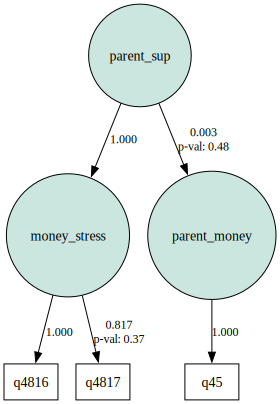

In [770]:
model = Model(model_desc)
model = fit_sem_model(model, df_support, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\support.png')

# 위험행동

In [588]:
df['q302'].value_counts()

q302
없다    1611
있다     316
Name: count, dtype: int64

In [589]:
crisis = df[['q287', 'q288', 'q289', 'q2810','q29', 'q31']]
crisis.isnull().sum()

q287     0
q288     0
q289     0
q2810    0
q29      0
q31      0
dtype: int64

In [590]:
crisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   q287    5376 non-null   category
 1   q288    5376 non-null   category
 2   q289    5376 non-null   category
 3   q2810   5376 non-null   category
 4   q29     5376 non-null   category
 5   q31     5376 non-null   category
dtypes: category(6)
memory usage: 32.5 KB


In [591]:
crisis = encoding(crisis, ['q287', 'q288', 'q289', 'q2810'], yes_or_no_map)
crisis = encoding(crisis, ['q29', 'q31'], how_much_is_map)
# crisis = encoding(crisis, ['q302'], is_or_not_map)

crisis = null0(crisis)

In [592]:
model_desc = """
    substance =~  q287 + q288 + q289
    impulse =~ q29 + q31
    crisis_behavior =~ substance + q2810 + impulse
"""

In [593]:
crisis['wt'] = df['wt']
observed_vars = ['q287', 'q288', 'q289', 'q2810', 'q29', 'q31']
w_cov_df = calculate_covariance(crisis, observed_vars)

적합도 지표:
                      Value
DoF               7.000000
DoF Baseline     15.000000
chi2            105.541518
chi2 p-value      0.000000
chi2 Baseline  3487.132623
CFI               0.971619
GFI               0.969734
AGFI              0.935144
NFI               0.969734
TLI               0.939184
RMSEA             0.051177
AIC              27.960736
BIC             120.216534
LogLik            0.019632 


모수 추정치:
                lval  op             rval  Estimate  Std. Err    z-value  \
0         substance   ~  crisis_behavior  1.000000         -          -   
1           impulse   ~  crisis_behavior  4.635411  0.596668   7.768834   
2              q287   ~        substance  1.000000         -          -   
3              q288   ~        substance  1.782693  0.122343  14.571281   
4              q289   ~        substance  0.511073  0.035059  14.577701   
5               q29   ~          impulse  1.000000         -          -   
6               q31   ~          impulse  0.71632

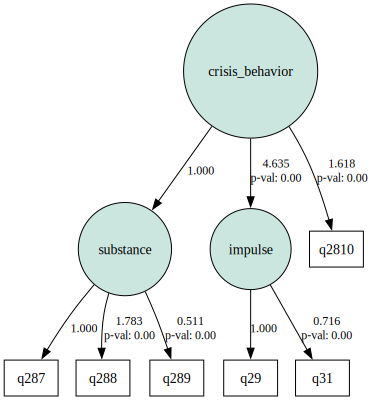

In [594]:
model = Model(model_desc)
model = fit_sem_model(model, crisis, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)


semplot(model, 'C:\\git_files\\education_analysis\\happy\\crisis.png')

        id sex  birthy birthm             area         size school grade  \
0  20001.0  여성  2003.0     4월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
1  20002.0  여성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
2  20003.0  여성  2003.0     9월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
3  20004.0  남성  2003.0     8월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   
4  20005.0  남성  2003.0     2월  충청권(대전, 충남, 충북)  도서벽지 및 읍면지역   고등학생   3학년   

  home1 home2  ... teacher_rel friend_rel parent_rel group_rel  \
0   아니오   아니오  ...   -0.106642   0.011224   0.077905 -0.187123   
1     예     예  ...   -0.028364   0.061383   0.117686  0.042647   
2     예     예  ...    0.219782  -0.066961  -0.063291  0.066684   
3     예     예  ...   -0.020977  -0.104962  -0.143006 -0.037296   
4   아니오     예  ...    0.241096   0.021382   0.134390  0.120427   

  emotional_state exposure_violence body_image_experience crisis_behavior  \
0       -0.167932         -0.024783             -0.468777       -0.01

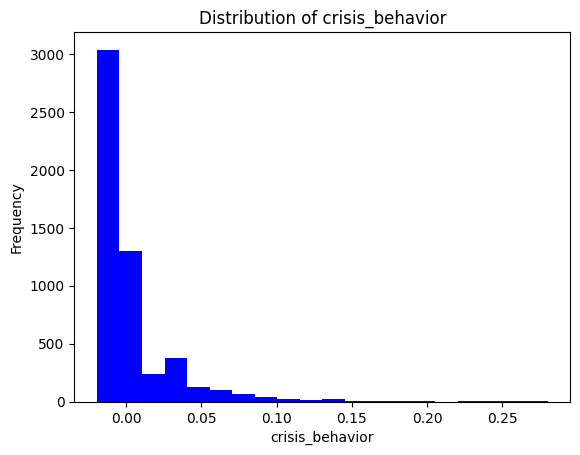

crisis_behavior
-0.019439    2599
 0.003816     482
-0.000076     473
-0.015546     352
 0.027071     170
             ... 
 0.168520       1
 0.095805       1
 0.186648       1
 0.094659       1
 0.164954       1
Name: count, Length: 83, dtype: int64

In [595]:
factor_scores = model.predict_factors(crisis)

df["crisis_behavior"] = factor_scores["crisis_behavior"]
df['impulse'] = factor_scores["impulse"]
df['substance'] = factor_scores["substance"]

print(df.head())

plt.hist(df["crisis_behavior"], bins=20, color='blue')
plt.title("Distribution of crisis_behavior")
plt.xlabel("crisis_behavior")
plt.ylabel("Frequency")
plt.show()
df['crisis_behavior'].value_counts()

# 조절효과 회귀분석 (OLS)

In [596]:
df = df[df['school'] == '고등학생']
df.head(3)

,id,sex,birthy,birthm,area,size,school,grade,home1,home2,...,teacher_rel,friend_rel,parent_rel,group_rel,emotional_state,exposure_violence,body_image_experience,crisis_behavior,impulse,substance
0,20001.0,여성,2003.0,4월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,아니오,아니오,...,-0.106642,0.011224,0.077905,-0.187123,-0.167932,-0.024783,-0.468777,-0.019439,-0.397509,-0.023640
1,20002.0,여성,2003.0,8월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,-0.028364,0.061383,0.117686,0.042647,0.058954,-0.024538,-0.366024,-0.019439,-0.397509,-0.023640
2,20003.0,여성,2003.0,9월,"충청권(대전, 충남, 충북)",도서벽지 및 읍면지역,고등학생,3학년,예,예,...,0.219782,-0.066961,-0.063291,0.066684,-0.085814,-0.024783,0.002915,-0.000076,0.323579,-0.010654


### emotional_state ~ academic_pressure + rel

In [597]:
df['interaction'] = df['academic_pressure'] * df['group_rel']

model = smf.ols('emotional_state ~ academic_pressure + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     442.9
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          1.90e-226
Time:                        15:03:16   Log-Likelihood:                 1654.2
No. Observations:                2272   AIC:                            -3300.
Df Residuals:                    2268   BIC:                            -3278.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0155      0.00

In [598]:
df['interaction'] = df['academic_pressure'] * df['teacher_rel']

model = smf.ols('emotional_state ~ academic_pressure + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     138.2
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.92e-82
Time:                        15:03:16   Log-Likelihood:                 1321.2
No. Observations:                2272   AIC:                            -2634.
Df Residuals:                    2268   BIC:                            -2611.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0170      0.00

In [599]:
df["interaction"] = df["academic_pressure"] * df["parent_rel"]

model = smf.ols("emotional_state ~ academic_pressure + parent_rel + interaction", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     243.9
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          3.86e-137
Time:                        15:03:16   Log-Likelihood:                 1448.0
No. Observations:                2272   AIC:                            -2888.
Df Residuals:                    2268   BIC:                            -2865.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0092      0.00

In [600]:
df['interaction'] = df['academic_pressure'] * df['friend_rel']

model = smf.ols('emotional_state ~ academic_pressure + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     238.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          2.60e-134
Time:                        15:03:16   Log-Likelihood:                 1441.5
No. Observations:                2272   AIC:                            -2875.
Df Residuals:                    2268   BIC:                            -2852.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0162      0.00

### impulse ~ violence + rel

In [601]:
df['interaction'] = df['exposure_violence'] * df['group_rel']

model = smf.ols('impulse ~ exposure_violence + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     52.22
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.25e-32
Time:                        15:03:16   Log-Likelihood:                -1776.8
No. Observations:                2272   AIC:                             3562.
Df Residuals:                    2268   BIC:                             3585.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0210      0.01

In [602]:
df['interaction'] = df['exposure_violence'] * df['teacher_rel']

model = smf.ols('impulse ~ exposure_violence + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     27.06
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           3.43e-17
Time:                        15:03:16   Log-Likelihood:                -1812.7
No. Observations:                2272   AIC:                             3633.
Df Residuals:                    2268   BIC:                             3656.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0207      0.01

In [603]:
df['interaction'] = df['exposure_violence'] * df['parent_rel']

model = smf.ols('impulse ~ exposure_violence + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     97.49
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.37e-59
Time:                        15:03:16   Log-Likelihood:                -1714.9
No. Observations:                2272   AIC:                             3438.
Df Residuals:                    2268   BIC:                             3461.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0064      0.01

In [604]:
df['interaction'] = df['exposure_violence'] * df['friend_rel']

model = smf.ols('impulse ~ exposure_violence + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     33.72
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.58e-21
Time:                        15:03:16   Log-Likelihood:                -1803.1
No. Observations:                2272   AIC:                             3614.
Df Residuals:                    2268   BIC:                             3637.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0202      0.01

### impulse ~ emotional_state + rel

In [605]:
df['interaction'] = df['emotional_state'] * df['group_rel']

model = smf.ols('impulse ~ emotional_state + group_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     171.2
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          4.81e-100
Time:                        15:03:16   Log-Likelihood:                -1620.8
No. Observations:                2272   AIC:                             3250.
Df Residuals:                    2268   BIC:                             3272.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0327      0.012     

In [606]:
df['interaction'] = df['emotional_state'] * df['teacher_rel']

model = smf.ols('impulse ~ emotional_state + teacher_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     166.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           2.58e-97
Time:                        15:03:16   Log-Likelihood:                -1627.1
No. Observations:                2272   AIC:                             3262.
Df Residuals:                    2268   BIC:                             3285.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0178      0.011     

In [607]:
df['interaction'] = df['emotional_state'] * df['parent_rel']

model = smf.ols('impulse ~ emotional_state + parent_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     192.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          5.13e-111
Time:                        15:03:16   Log-Likelihood:                -1595.4
No. Observations:                2272   AIC:                             3199.
Df Residuals:                    2268   BIC:                             3222.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0287      0.011     

In [608]:
df['interaction'] = df['emotional_state'] * df['friend_rel']

model = smf.ols('impulse ~ emotional_state + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     169.3
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           4.97e-99
Time:                        15:03:16   Log-Likelihood:                -1623.1
No. Observations:                2272   AIC:                             3254.
Df Residuals:                    2268   BIC:                             3277.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0258      0.011     

In [609]:
df['interaction'] = df['emotional_state'] * df['human_rel']

model = smf.ols('impulse ~ emotional_state + human_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                impulse   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     170.7
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          8.68e-100
Time:                        15:03:16   Log-Likelihood:                -1621.4
No. Observations:                2272   AIC:                             3251.
Df Residuals:                    2268   BIC:                             3274.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0320      0.012     

### substance ~ rel + rel

In [610]:
df['interaction'] = df['parent_rel'] * df['friend_rel']

model = smf.ols('substance ~ parent_rel + friend_rel + interaction', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              substance   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     16.68
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           1.02e-10
Time:                        15:03:16   Log-Likelihood:                 2962.7
No. Observations:                2272   AIC:                            -5917.
Df Residuals:                    2268   BIC:                            -5894.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0059      0.002      3.829      

In [611]:
df['interaction'] = df['parent_rel'] * df['substance'] 

# OLS 모델 작성
model = smf.ols('emotional_state ~ parent_rel + substance + interaction', data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        emotional_state   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     243.8
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          4.10e-137
Time:                        15:03:16   Log-Likelihood:                 1447.9
No. Observations:                2272   AIC:                            -2888.
Df Residuals:                    2268   BIC:                            -2865.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0081      0.003     -2.998      

# 종합

In [612]:
everything = pd.concat([df_edu, df_rel, emo, body, df_vio, crisis], axis=1)

In [613]:
everything = everything.loc[:, ~everything.columns.duplicated()]

In [614]:
everything.head(3)

,q071,q072,q073,q074,q485,q486,q487,q488,wt,q05,...,q33,q35,q351,q352,q287,q288,q289,q2810,q29,q31
0,0,0,0,2,3,2,4,0,0.250048,1.00,...,0,0,0.0,0.0,0,0,0,0,0,0
1,1,1,1,1,1,1,2,2,0.250048,0.75,...,1,0,0.0,0.0,0,0,0,0,0,0
2,0,0,0,0,2,2,2,2,0.250048,1.00,...,0,0,0.0,0.0,0,0,0,0,1,0


In [615]:
model_desc = """
academic_stress =~ q072 + q073
exam_anxiety =~ q485 + q486 + q487 + q488
academic_pressure =~  academic_stress + exam_anxiety

friend_rel =~ q132 + q136
teacher_rel =~ q061 + q062
father_rel =~ q161 + q162
mother_rel =~ q171 + q172
parent_rel =~ father_rel + mother_rel
group_rel =~ q224 + q225
human_rel =~ friend_rel + teacher_rel + parent_rel + group_rel
father_rel ~~ mother_rel

emotional_state =~ q221 + q223 + q226 + q23

body_image_stress =~ q4812 + q4813 + q4814 + q4815
body_info =~ obesity

body_image_experience =~ body_image_stress
body_image_experience =~ body_info

exposure_violence =~ q35 + q351 + q352

substance =~  q287 + q288 + q289
impulse =~ q29 + q31
crisis_behavior =~ substance + q2810 + impulse


# [1] 정서 상태(emotional_state)에 영향을 주는 요인들
emotional_state ~ academic_pressure          # 학업 압박이 정서 상태에 영향
emotional_state ~ human_rel                  # 인간 관계 → 정서 안정
emotional_state ~ body_image_experience      # 신체 이미지 경험 → 정서 상태
emotional_state ~ academic_stress            # 학업 스트레스 → 정서 상태
emotional_state ~ exposure_violence          # 폭력 노출 → 정서 상태
emotional_state ~ parent_rel                 # 부모와의 관계 → 정서 상태
emotional_state ~ friend_rel                 # 친구 관계 → 정서 상태

# [2] 충동성과 위기행동에 영향을 주는 정서 상태
impulse ~ emotional_state                    # 감정 상태 → 충동성
crisis_behavior ~ emotional_state            # 정서 상태 → 위기 행동

# [3] 폭력 노출의 영향
impulse ~ exposure_violence                  # 폭력 경험 → 충동성
human_rel ~ exposure_violence                # 폭력 경험 → 인간관계 악화

# [4] 학업 압박 관련 경로들
academic_pressure ~ emotional_state          # 정서 상태 → 학업 압박
academic_pressure ~ exam_anxiety             # 시험 불안 → 학업 압박
academic_pressure ~ teacher_rel              # 교사 관계 → 학업 압박
academic_pressure ~ human_rel                # 인간 관계 악화 → 학업 압박 증가

# [5] 학업 스트레스 관련 경로
academic_stress ~ human_rel                  # 좋은 인간 관계 → 학업 스트레스 완충
academic_stress ~ parent_rel                 # 부모 관계 → 학업 스트레스

# [6] 인간 관계에 영향을 주는 경로
human_rel ~ academic_pressure                # 학업 압박 → 인간 관계 악화
parent_rel ~ substance                       # 물질 사용 → 부모 관계 악화

# [7] 충동성과 위기행동
impulse ~ academic_pressure                  # 학업 압박 → 충동성
impulse ~ friend_rel                         # 친구 관계 → 충동 억제
crisis_behavior ~ academic_pressure          # 학업 압박 → 위기 행동

# [8] 정서 ↔ 신체 이미지 경험 간 상호작용
body_image_experience ~ emotional_state      # 정서 상태 → 신체 이미지 인식

"""

observed_vars = [
    'q072', 'q073', 'q485', 'q486', 'q487', 'q488', 'q221', 'q223', 'q226', 'q23',
    'q132', 'q136', 'q061', 'q062', 'q161', 'q162', 'q171', 'q172', 'q224', 'q225',
    'q4812', 'q4813', 'q4814', 'q4815', 'obesity', 'q42', 'q43',
    'q33', 'q35', 'q351', 'q352', 
    'q287', 'q288', 'q289', 'q2810','q29', 'q31'
                ]
w_cov_df = calculate_covariance(everything, observed_vars)
vif_df = compute_vif(everything, observed_vars)
model = Model(model_desc)
model = fit_sem_model(model, everything, w_cov_df)
stats = calc_stats(model)
estimates = model.inspect()
print("적합도 지표:\n", stats.T, "\n\n")
print("모수 추정치:\n", estimates)

semplot(model, 'C:\\git_files\\education_analysis\\happy\\everything.png')
report(model, 'C:\\git_files\\education_analysis\\happy\\report')

적합도 지표:
                       Value
DoF              491.000000
DoF Baseline     561.000000
chi2            4141.351032
chi2 p-value       0.000000
chi2 Baseline  80306.746777
CFI                0.954225
GFI                0.948431
AGFI               0.941079
NFI                0.948431
TLI                0.947699
RMSEA              0.037191
AIC              206.459319
BIC              891.788107
LogLik             0.770341 


모수 추정치:
                 lval  op               rval  Estimate  Std. Err    z-value  \
0    academic_stress   ~  academic_pressure  1.000000         -          -   
1       exam_anxiety   ~  academic_pressure -0.052574   0.08752  -0.600709   
2         father_rel   ~         parent_rel  1.000000         -          -   
3         mother_rel   ~         parent_rel  0.880626  0.033285  26.456902   
4         friend_rel   ~          human_rel  1.000000         -          -   
..               ...  ..                ...       ...       ...        ...   
117          

In [616]:
def format_value(x):
    try:
        if str(x).strip() == '-':
            return x
        return f"{float(x):.6f}"
    except:
        return x

In [617]:
def standardize_estimates_full(estimates_df, data):
    """
    semopy 모델의 결과 DataFrame(estimates_df)에 대해 표준화 계수를 계산하는 함수.
    - 회귀 계수(op='~') 및 요인 부하량(op='=~')에 대해 계산.
    
    Parameters:
        estimates_df (pd.DataFrame): semopy의 model.inspect() 결과
        data (pd.DataFrame): 원자료 또는 잠재변수 점수가 포함된 데이터프레임

    Returns:
        pd.DataFrame: std_estimate 열이 추가된 DataFrame
    """
    std_estimates = []

    for _, row in estimates_df.iterrows():
        op = row['op']
        lhs = row['lval']
        rhs = row['rval']
        estimate = row['Estimate']

        if op == '~':  # 회귀 관계: lhs ~ rhs
            if lhs in data.columns and rhs in data.columns:
                try:
                    std_lhs = np.std(data[lhs], ddof=1)
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_beta = estimate * (std_rhs / std_lhs)
                    std_estimates.append(std_beta)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        elif op == '=~':  # 요인 부하량: latent =~ indicator
            if rhs in data.columns:
                try:
                    std_rhs = np.std(data[rhs], ddof=1)
                    std_loading = estimate * std_rhs  # 잠재변수는 단위분산 가정
                    std_estimates.append(std_loading)
                except Exception:
                    std_estimates.append(np.nan)
            else:
                std_estimates.append(np.nan)

        else:
            std_estimates.append(np.nan)

    estimates_df['std_estimate'] = std_estimates
    return estimates_df


In [618]:
factor_scores = model.predict_factors(everything)
combined_df = pd.concat([everything.copy(), factor_scores], axis=1)
estimates_df = model.inspect()
std_estimates_df = standardize_estimates_full(estimates_df, combined_df)

# 결과 확인
pd.set_option('display.max_rows', None)
display(std_estimates_df)
pd.reset_option('display.max_rows')

,lval,op,rval,Estimate,Std. Err,z-value,p-value,std_estimate
0,academic_stress,~,academic_pressure,1.000000,-,-,-,1.912185
1,exam_anxiety,~,academic_pressure,-0.052574,0.08752,-0.600709,0.548034,-0.079473
2,father_rel,~,parent_rel,1.000000,-,-,-,0.506608
3,mother_rel,~,parent_rel,0.880626,0.033285,26.456902,0.0,0.568227
4,friend_rel,~,human_rel,1.000000,-,-,-,0.738106
5,teacher_rel,~,human_rel,1.654075,0.097646,16.939583,0.0,0.559854
6,parent_rel,~,human_rel,1.165333,0.072432,16.088673,0.0,0.734055
7,group_rel,~,human_rel,2.393906,0.132022,18.132584,0.0,0.930373
8,body_image_stress,~,body_image_experience,1.000000,-,-,-,0.873391
9,body_info,~,body_image_experience,0.175190,0.030948,5.660766,0.0,0.382907


In [619]:
for col in ['Estimate', 'Std. Err', 'z-value', 'p-value', 'std_estimate']:
    if col in std_estimates_df.columns:
        std_estimates_df[col] = std_estimates_df[col].apply(format_value)

std_estimates_df.to_csv('c:\\git_files\\education_analysis\\happy\\estimates.csv', index=False)
df.to_csv('c:\\git_files\\education_analysis\\happy\\final_df.csv', index=False)